<a href="https://colab.research.google.com/github/adrianobav/trabalho_estatistica/blob/main/Estatistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, shapiro, levene, pearsonr, probplot

# Determinar o dispositivo de referência
dispositivo_referencia = "BRACELET"

# Função para carregar dados de múltiplas planilhas
def carregar_dados(arquivo, sheets):
    """
    Carrega os dados de múltiplas planilhas de um arquivo Excel.
    Args:
        arquivo (str): Nome do arquivo Excel.
        sheets (list): Lista de planilhas a serem carregadas.
    Returns:
        dict: Dicionário com os dados de cada planilha.
    """
    data = {}
    for sheet in sheets:
        data[sheet] = pd.read_excel(arquivo, sheet_name=sheet, index_col=0)
    return data

# Função para preparar os dados de medições
def preparar_dados(data, dispositivo):
    """
    Prepara os dados de medições para análise.
    Args:
        data (dict): Dados carregados.
        dispositivo (str): Nome do dispositivo a ser processado.
    Returns:
        list: Lista de DataFrames com as medições de cada voluntário.
    """
    medicoes = []
    for id_voluntario in data[dispositivo].index:
        df = pd.DataFrame(columns=['EXPERIMENTO', 'PS', 'PD', 'PM'])
        df['EXPERIMENTO'] = [f"Exp {i}" for i in range(1, 11)]
        df['PS'] = [data[dispositivo].loc[id_voluntario][f'PS{i}'] for i in range(1, 11)]
        df['PD'] = [data[dispositivo].loc[id_voluntario][f'PD{i}'] for i in range(1, 11)]
        df['PM'] = [data[dispositivo].loc[id_voluntario][f'PM{i}'] for i in range(1, 11)]
        df.set_index('EXPERIMENTO', inplace=True)
        medicoes.append(df)
    return medicoes

# Função para realizar análise ANOVA
def realizar_anova(dados, dispositivos, f_critico, alpha=0.05):
    """
    Realiza análise ANOVA para comparar os dispositivos.
    Args:
        dados (dict): Dados das medições.
        dispositivos (list): Lista de dispositivos.
        f_critico (float): Valor crítico de F.
        alpha (float): Nível de significância.
    Returns:
        tuple: Quantidade de rejeições e não rejeições de H0.
    """
    h0, h1 = 0, 0
    for voluntario in range(len(dados[dispositivos[0]])):
        f, p = f_oneway(
            *[dados[dispositivo][voluntario]['PM'] for dispositivo in dispositivos]
        )
        if f > f_critico and p < alpha:
            h1 += 1
        else:
            h0 += 1
    return h0, h1

# Função para realizar Teste T entre pares de dispositivos
def realizar_teste_t(dados, pares_dispositivos, alpha=0.05):
    """
    Realiza Teste T para pares de dispositivos.
    Args:
        dados (dict): Dados das medições.
        pares_dispositivos (list): Pares de dispositivos para comparação.
        alpha (float): Nível de significância.
    Returns:
        dict: Resultados do Teste T para cada par.
    """
    resultados = {}
    for dispositivo1, dispositivo2 in pares_dispositivos:
        h0, h1 = 0, 0
        for voluntario in range(len(dados[dispositivo1])):
            _, p = ttest_ind(
                dados[dispositivo1][voluntario]['PM'],
                dados[dispositivo2][voluntario]['PM'],
                equal_var=False
            )
            if p < alpha:
                h0 += 1
            else:
                h1 += 1
        resultados[f"{dispositivo1} vs {dispositivo2}"] = {'h0': h0, 'h1': h1}
    return resultados


# Função para realizar grafico_barras_proporcoes
def grafico_barras_proporcoes(testes, h0_rejeitada, h0_nao_rejeitada):
    """
    Cria um gráfico de barras empilhadas para proporções de H0 rejeitada e não rejeitada.
    Args:
        testes (list): Lista com os nomes dos testes.
        h0_rejeitada (list): Quantidade de H0 rejeitadas para cada teste.
        h0_nao_rejeitada (list): Quantidade de H0 não rejeitadas para cada teste.
    """
    x = range(len(testes))  # Eixo X com base no número de testes
    plt.bar(x, h0_rejeitada, label='H0 Rejeitada', color='blue')
    plt.bar(x, h0_nao_rejeitada, bottom=h0_rejeitada, label='H0 Não Rejeitada', color='orange')
    plt.xticks(x, testes, rotation=45)  # Nomes dos testes no eixo X
    plt.ylabel("Número de Voluntários")
    plt.title("Resultados dos Testes T")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Função para criar Boxplot comparativos entre dispositivos
def grafico_boxplots_comparativos(medicoes, pares_dispositivos):
    """
    Cria boxplots comparativos para pares de dispositivos.
    Args:
        medicoes (dict): Dicionário com dados das medições por dispositivo.
        pares_dispositivos (list): Lista de tuplas com pares de dispositivos.
    """
    fig, ax = plt.subplots(1, len(pares_dispositivos), figsize=(15, 5))
    for i, (dispositivo1, dispositivo2) in enumerate(pares_dispositivos):
        # Extrair dados de PM para ambos os dispositivos
        dados1 = [valor for df in medicoes[dispositivo1] for valor in df['PM']]
        dados2 = [valor for df in medicoes[dispositivo2] for valor in df['PM']]
        # Criar boxplot para o par
        ax[i].boxplot([dados1, dados2], labels=[dispositivo1, dispositivo2])
        ax[i].set_title(f"{dispositivo1} vs {dispositivo2}")
        ax[i].set_ylabel("Pressão Média (PM)")
    plt.tight_layout()
    plt.show()



# Função para gráfico Q-Q Plot
def plot_qq(dados, dispositivo):
    """
    Gera o gráfico Q-Q Plot para verificar normalidade.
    Args:
        dados (list): Dados do dispositivo.
        dispositivo (str): Nome do dispositivo.
    """
    probplot(dados, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot - {dispositivo}")
    plt.xlabel("Quantis Teóricos")
    plt.ylabel("Quantis Observados")
    plt.show()

# Função para gráficos de densidade (KDE)
def grafico_densidade_kde(medicoes, pares_dispositivos):
    """
    Gera gráficos de densidade (KDE) para pares de dispositivos.
    Args:
        medicoes (dict): Dados das medições.
        pares_dispositivos (list): Pares de dispositivos para comparação.
    """
    for dispositivo1, dispositivo2 in pares_dispositivos:
        dados1 = [valor for df in medicoes[dispositivo1] for valor in df['PM']]
        dados2 = [valor for df in medicoes[dispositivo2] for valor in df['PM']]
        sns.kdeplot(dados1, label=dispositivo1, fill=True, color="blue", alpha=0.5)
        sns.kdeplot(dados2, label=dispositivo2, fill=True, color="orange", alpha=0.5)
        plt.title(f"[Gráfico de Densidade (KDE)] - {dispositivo1} vs {dispositivo2}")
        plt.xlabel("Pressão Média (PM)")
        plt.ylabel("Densidade")
        plt.legend()
        plt.show()

def analise_correlacao(dados1, dados2, dispositivo1, dispositivo2):
    """
    Realiza análise de correlação entre dois dispositivos.
    Args:
        dados1 (list): Dados do dispositivo 1.
        dados2 (list): Dados do dispositivo 2.
        dispositivo1 (str): Nome do dispositivo 1.
        dispositivo2 (str): Nome do dispositivo 2.
    Returns:
        dict: Resultado da correlação.
    """
    correlacao, p_valor = pearsonr(dados1, dados2)  # Correção aqui
    return {
        "comparacao": f"{dispositivo1} vs {dispositivo2}",
        "correlacao": correlacao,
        "p_valor": p_valor
    }


# Análise Estatística dos Dispositivos de Medição de Pressão Arterial

Este notebook apresenta a análise estatística dos dispositivos de medição de pressão arterial, utilizando técnicas como ANOVA, Testes T, gráficos de densidade (KDE), e análise de correlação. O dispositivo de referência escolhido para comparação é o **BRACELET**.


## 1. Carregar e Preparar os Dados

Inicialmente, carregamos os dados das medições a partir de um arquivo Excel contendo as planilhas correspondentes aos dispositivos: **PULSO**, **BRACO**, **OURO** e **BRACELET**. Cada planilha contém medições realizadas em 10 experimentos por voluntário.

Em seguida, os dados são preparados para análise, estruturando as medições em um formato uniforme.


In [3]:
# Nome do arquivo Excel
arquivo = 'dados.xlsx'

# Lista de planilhas (dispositivos)
sheets = ['PULSO', 'BRACO', 'OURO', 'BRACELET']

# 1. Carregar os dados
data = carregar_dados(arquivo, sheets)

# 2. Preparar os dados de medições para todos os dispositivos
medicoes = {dispositivo: preparar_dados(data, dispositivo) for dispositivo in sheets}


## 2. Análise Descritiva: Boxplots

Para visualizar as distribuições das medições de pressão média (PM) entre os dispositivos, criamos gráficos de boxplot dispostos em uma grade 2x2. Os limites dos eixos são uniformes para facilitar a comparação.


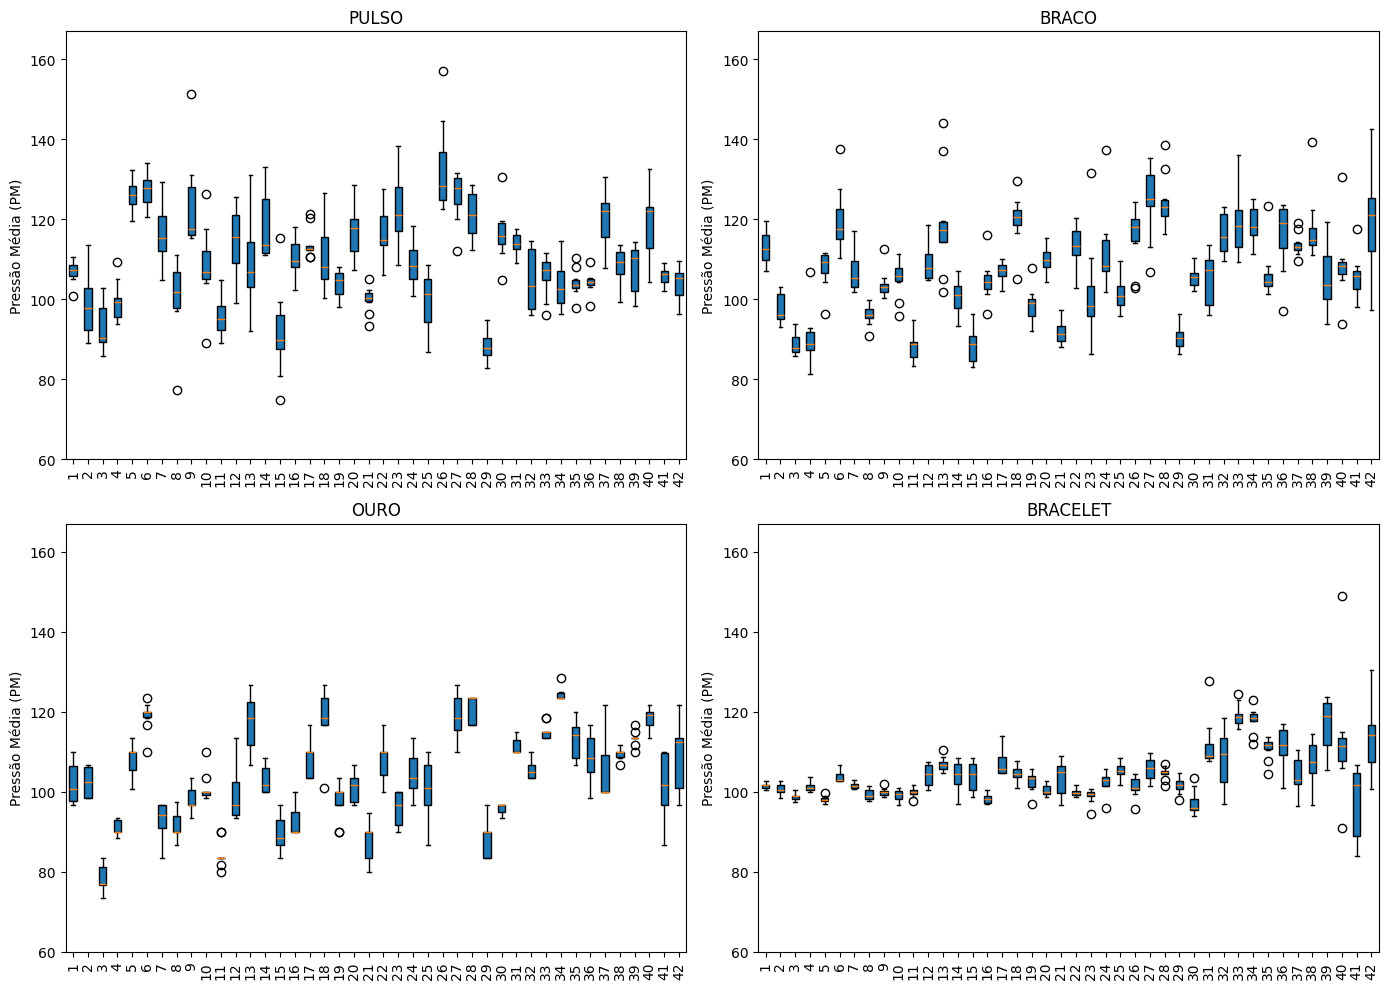

In [9]:
# Encontrar os valores máximo e mínimo gerais
todos_os_valores = [
    valor for dispositivo in medicoes.values() for df in dispositivo for valor in df['PM']
]
y_min = 60
y_max = max(todos_os_valores) + 10  # Margem acima do máximo

# Configurar a grade 2x2 para os gráficos
fig, ax = plt.subplots(2, 2, figsize=(14, 10))  # Configura grade 2x2

# Criar os gráficos para cada dispositivo
for i, dispositivo in enumerate(sheets):
    row, col = divmod(i, 2)  # Determinar a posição no grid 2x2
    dados_pm = [df['PM'] for df in medicoes[dispositivo]]
    ax[row, col].boxplot(dados_pm, patch_artist=True)
    ax[row, col].set_title(dispositivo)
    ax[row, col].set_ylabel("Pressão Média (PM)")
    ax[row, col].set_ylim(y_min, y_max)  # Definir limites iguais para todos
    ax[row, col].tick_params(axis='x', rotation=90)  # Garantir rotação dos rótulos

plt.tight_layout()
plt.show()


## 3. Análise de Variância (ANOVA)

A ANOVA (Análise de Variância) foi utilizada para verificar se existem diferenças estatisticamente significativas entre as médias das medições dos dispositivos. Consideramos um valor crítico de **F = 2.9** e nível de significância de **α = 0.05**.


In [10]:
# 3. Realizar ANOVA
f_critico = 2.9  # Valor crítico baseado em tabelas F
alpha = 0.05     # Nível de significância

h0_anova, h1_anova = realizar_anova(medicoes, sheets, f_critico, alpha)
print("\n==== Análise ANOVA ====")
print(f"Número de voluntários que rejeitaram H0: {h1_anova}")
print(f"Número de voluntários que não rejeitaram H0: {h0_anova}")



==== Análise ANOVA ====
Número de voluntários que rejeitaram H0: 39
Número de voluntários que não rejeitaram H0: 3


## 4. Testes T entre Pares de Dispositivos

Testes T foram aplicados para comparar as medições de pressão média (PM) entre pares de dispositivos, sempre utilizando o dispositivo **BRACELET** como referência.



==== Resultados dos Testes T ====
BRACO vs BRACELET: H0 rejeitada em 33 casos, não rejeitada em 9 casos.
PULSO vs BRACELET: H0 rejeitada em 32 casos, não rejeitada em 10 casos.
OURO vs BRACELET: H0 rejeitada em 20 casos, não rejeitada em 22 casos.


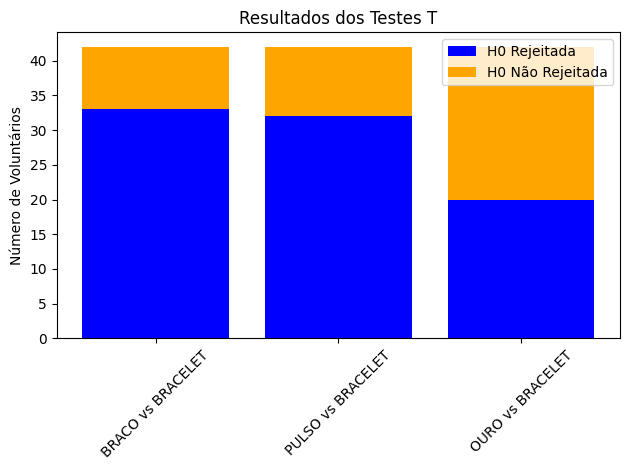

In [13]:
# 4. Realizar Teste T
pares_dispositivos = [
    ('BRACO', 'BRACELET'),
    ('PULSO', 'BRACELET'),
    ('OURO', 'BRACELET')
]

resultados_teste_t = realizar_teste_t(medicoes, pares_dispositivos, alpha)
print("\n==== Resultados dos Testes T ====")
for par, resultado in resultados_teste_t.items():
    print(f"{par}: H0 rejeitada em {resultado['h0']} casos, não rejeitada em {resultado['h1']} casos.")

# Extrair os resultados reais dos testes T
testes = list(resultados_teste_t.keys())  # Obter os pares de comparação
h0_rejeitada = [resultados_teste_t[teste]["h0"] for teste in testes]
h0_nao_rejeitada = [resultados_teste_t[teste]["h1"] for teste in testes]

# Gerar o gráfico com os valores do projeto
grafico_barras_proporcoes(testes, h0_rejeitada, h0_nao_rejeitada)


## 5. Visualização com Gráficos de Densidade (KDE)

Os gráficos de densidade (KDE) permitem comparar as distribuições das medições entre pares de dispositivos. Eles fornecem uma visão intuitiva da sobreposição das distribuições.


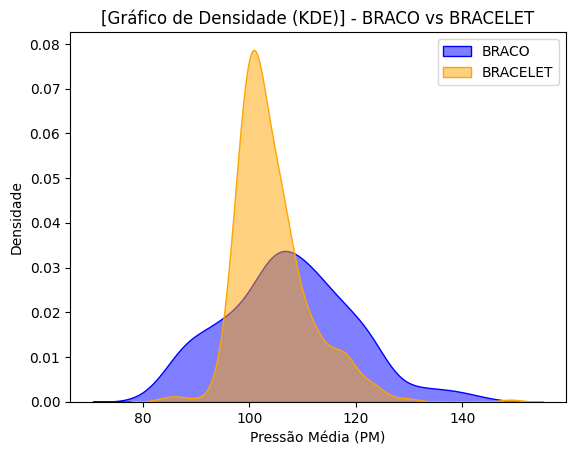

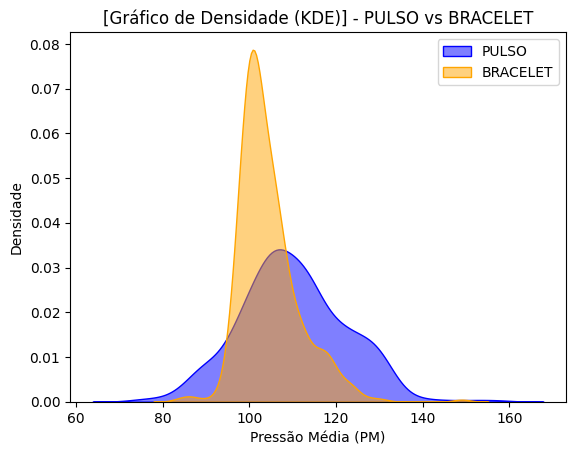

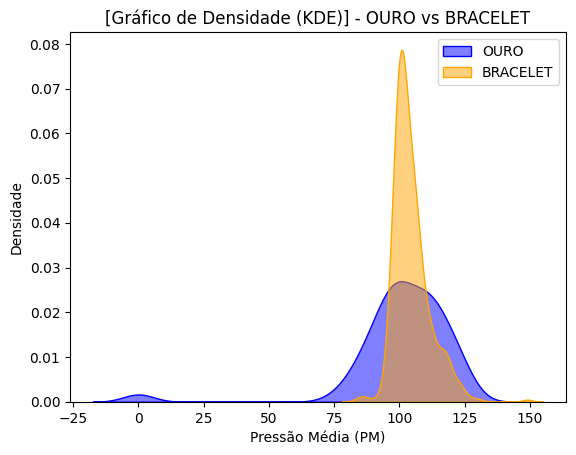

In [14]:
grafico_densidade_kde(medicoes, pares_dispositivos)


## 6. Verificação de Normalidade com Q-Q Plot

O teste de normalidade foi realizado utilizando gráficos Q-Q Plot para verificar o alinhamento dos dados com uma distribuição normal.


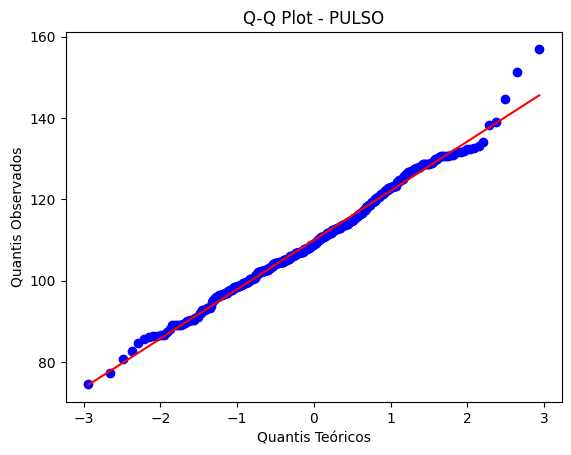

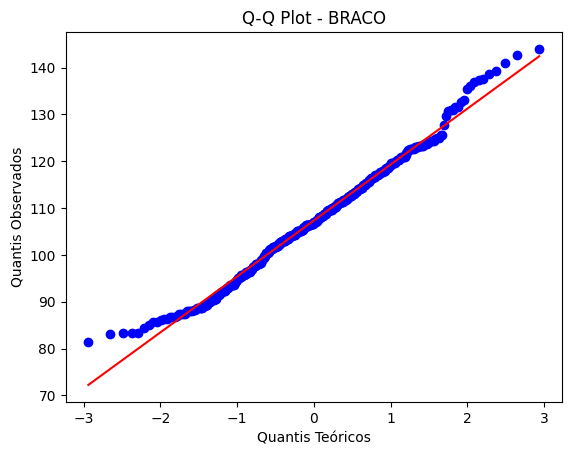

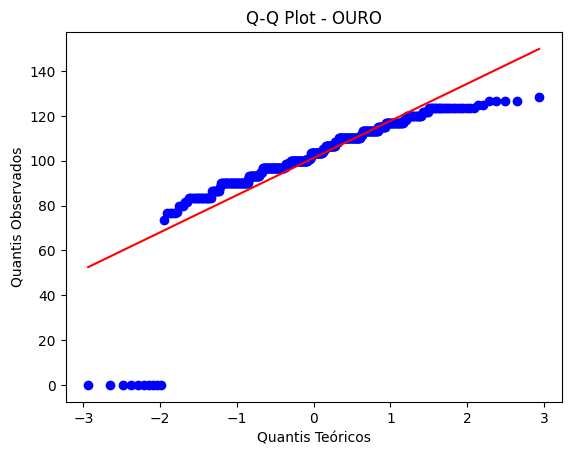

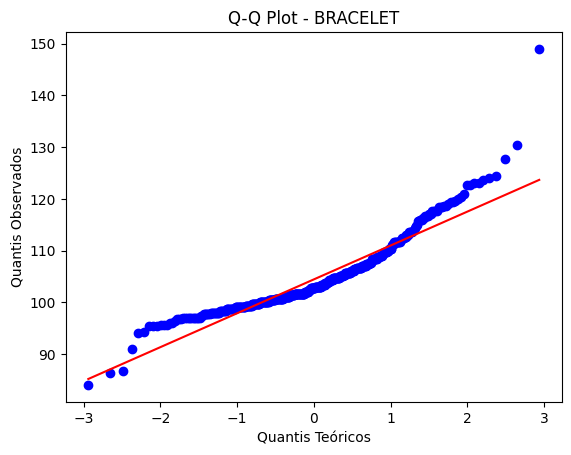

In [15]:
for dispositivo, dados in medicoes.items():
    dados_dispositivo = [valor for df in dados for valor in df['PM']]
    plot_qq(dados_dispositivo, dispositivo)


## 7. Análise de Correlação

A correlação entre as medições de cada dispositivo e o dispositivo de referência foi analisada utilizando o coeficiente de correlação de Pearson.



==== Análise de Correlação ====
Correlação entre PULSO vs BRACELET: -0.07 (p-valor: 0.1552)


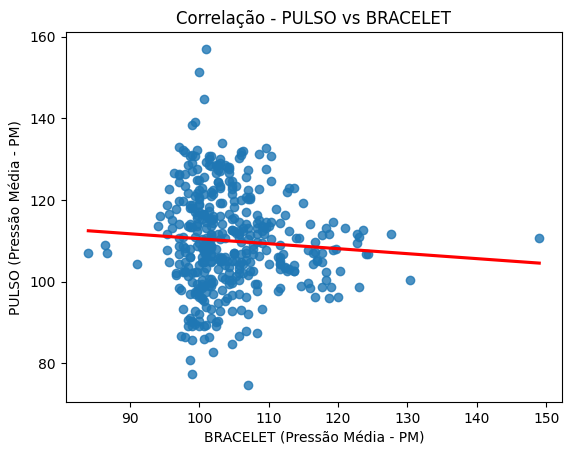

Correlação entre BRACO vs BRACELET: 0.30 (p-valor: 0.0000)


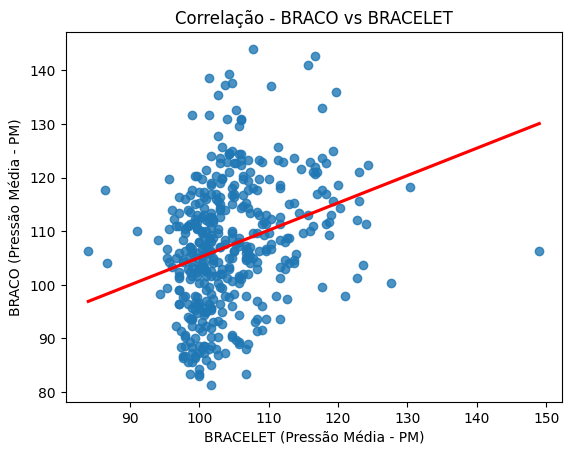

Correlação entre OURO vs BRACELET: 0.33 (p-valor: 0.0000)


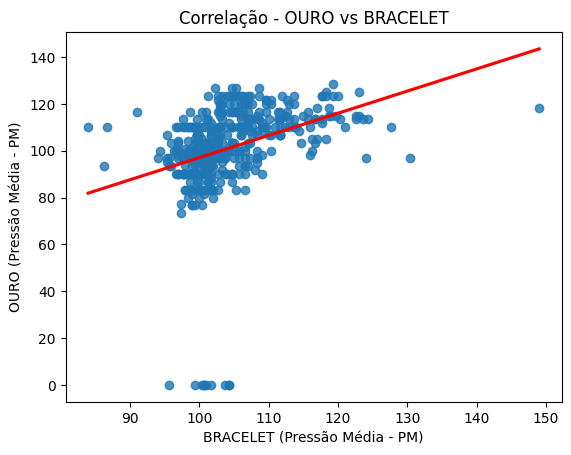

In [16]:
print("\n==== Análise de Correlação ====")
for dispositivo, dados in medicoes.items():
    if dispositivo == dispositivo_referencia:
        continue
    dados_referencia = [valor for df in medicoes[dispositivo_referencia] for valor in df['PM']]
    dados_dispositivo = [valor for df in dados for valor in df['PM']]
    resultado_correlacao = analise_correlacao(dados_dispositivo, dados_referencia, dispositivo, dispositivo_referencia)
    print(f"Correlação entre {resultado_correlacao['comparacao']}: {resultado_correlacao['correlacao']:.2f} (p-valor: {resultado_correlacao['p_valor']:.4f})")
    sns.regplot(x=dados_referencia, y=dados_dispositivo, ci=None, line_kws={"color": "red"})
    plt.title(f"Correlação - {dispositivo} vs {dispositivo_referencia}")
    plt.xlabel(f"{dispositivo_referencia} (Pressão Média - PM)")
    plt.ylabel(f"{dispositivo} (Pressão Média - PM)")
    plt.show()
